In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
from depsurf import OUTPUT_PATH, Versions, DiffResult, DepKind
from utils import dump_pkl

groups = [Versions.LTS, Versions.REGULAR, Versions.REV]
# groups = [Versions.TEST]

results: DiffResult = {}

for group in groups:
    result = group.diff_pairs(
        kinds=[
            DepKind.FUNC,
            DepKind.STRUCT,
            DepKind.TRACEPOINT,
            DepKind.LSM,
        ],
        result_path=OUTPUT_PATH / "src" / group.name,
    )
    results.update(result)

dump_pkl(results, "src/summary")

[        utils.py:160] INFO: NumExpr defaulting to 8 threads.
[     versions.py:153] INFO: Diffing LTS
[     versions.py:161] INFO: Comparing 4.4_4.15 to /Users/szhong/Downloads/bpf-study/output/src/LTS/4.4_4.15
[          btf.py:21 ] INFO: Loading BTF from /Users/szhong/Downloads/bpf-study/data/btf_norm/4.4.0-21-generic-amd64.pkl
[          btf.py:21 ] INFO: Loading BTF from /Users/szhong/Downloads/bpf-study/data/btf_norm/4.15.0-20-generic-amd64.pkl
[       symtab.py:70 ] INFO: Loading symtab from /Users/szhong/Downloads/bpf-study/data/symtab/4.4.0-21-generic-amd64.jsonl
[       symtab.py:70 ] INFO: Loading symtab from /Users/szhong/Downloads/bpf-study/data/symtab/4.15.0-20-generic-amd64.jsonl
[     syscalls.py:54 ] WARNING: Unknown syscall at 513: ffffffff81e011a8 -> ffffffff8102cbd0
[     versions.py:161] INFO: Comparing 4.15_5.4 to /Users/szhong/Downloads/bpf-study/output/src/LTS/4.15_5.4
[          btf.py:21 ] INFO: Loading BTF from /Users/szhong/Downloads/bpf-study/data/btf_norm/

In [4]:
import pandas as pd
from depsurf.output import load_pkl

data: "ResultsType" = load_pkl("src/summary")

df = pd.DataFrame(data)
df = df.loc[(df != 0).any(axis=1)]
df

[        utils.py:19 ] INFO: Loding src/summary from /Users/szhong/Downloads/bpf-study/output/src/summary.pkl


LTS                                                                                                                                                                                                Regular                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               \
                               (4.4.0-21-generic-amd64, 4.15.0-20-generic-amd64) (4.15.0-20-generic-amd64, 5.4.0-26-generic-amd64) (5.4.0-26-generic-amd64, 5.15.0-25-generic-amd64) (5.15.0-25-generic-amd64, 6.8.0-31-generic-amd64) (4.4.0-21-generic-amd64, 4.8.0-22-generic-amd64) (4.8.0-22-generic-amd64, 4.10.0-19-generic-amd64) (4.10.0-19-generic-amd64, 4.13.0-16-generic-amd64) (4.13.0-16-generic-amd64, 4.15.0-20-generic-amd64) (4.15.0-20-generic-amd64, 4.18.0-10-generic-amd64) (4.18.0-10-generic-amd64, 5.0.0-13-generic-amd64) (5.0.0-13-generic-amd64, 5.3.0-18-generic-amd64) (5.3.0-18-generic-amd64, 5.4.0-26-generic-amd64) (5.4.0-26-generic-amd64, 5.8.0-25-generic-amd64) (5.8.0-25-generic-amd64, 5.11.0-16-generic-amd64) (5.11.0-16-generic-amd64, 5.13.0-19-generic-amd64) (5.13.0-19-generic-amd64, 5.15.0-25-generic-amd64) (5.15.0-25-generic-amd64, 5.19.0-21-generic-amd64) (5.19.0-21-generic-amd64, 6.2.0-20-generic-amd64) (6.2.0-20-generic-amd64, 6.5.0-9-generic-amd64)   
Function   Old                                                             36309                                             42299                                             48018                                             53956                                            36309                                             38211                                              39148                                              40741                                              42299                                             44488                                            45277                                            46992                                            48018                                             51936                                              54302                                              53193                                              53956                                             55843                                           56978   
           New                                                             42299                                             48018                                             53956                                             61983                                            38211                                             39148                                              40741                                              42299                                              44488                                             45277                                            46992                                            48018                                            51936                                             54302                                              53193                                              53956                                              55843                                             56978                                           59365   
           Added                                                            8600                                              8929           

In [5]:
import re

import pandas as pd

from depsurf import DepKind, IssueEnum, Versions, DiffResult
from utils import (
    GRAY_DASH,
    load_pkl,
    save_latex,
    rotate_multirow,
    replace_cline,
)

data:  DiffResult = load_pkl("src/summary")


col_names = {
    "Old": r"\multicolumn{1}{c}{\ No.}",
    IssueEnum.ADD: r"\multicolumn{1}{c}{$+$\tiny\%}",
    IssueEnum.REMOVE: r"\multicolumn{1}{c}{$-$\tiny\%}",
    IssueEnum.CHANGE: r"\multicolumn{1}{c|}{$\Delta$\tiny\%}",
}

group_names = {
    Versions.LTS: "LTS (2 yr)",
    Versions.REGULAR: "Regular Releases (6 mo)",
    # Versions.REV: "Revisions for 5.4",
}


results = {}

for (group, pair), diffs in data.items():
    if group not in group_names:
        continue

    result = {}
    old = 0
    for (kind, key), s in diffs.items():
        if kind == DepKind.SYSCALL:
            continue

        if key not in col_names.keys():
            continue

        display_key = col_names[key]

        if key == "Old":
            old = s
            if kind == DepKind.FUNC:
                s = f"{s / 1000:.0f}k"
            elif kind == DepKind.STRUCT:
                s = f"{s / 1000:.1f}k"
        else:
            if s == 0:
                s = GRAY_DASH
            else:
                # v = str(int(v / old * 100))
                s = f"{s / old * 100:.0f}"
            # elif group == Versions.REV:
            #     v = str(v)
            # else:
            #     v = str(int(v / old * 100)) + r"{\tiny\%}"

        s = r"\multirow{2}{*}{" + str(s) + "}"
        result[(kind, display_key)] = s

    v1 = group.version_to_str(pair.v1, bold=True)
    v2 = group.version_to_str(pair.v2, bold=True)

    group_name = group_names[group]
    results[(group_name, v1)] = result
    if pair.v2 == list(group)[-1]:
        results[(group_name, v2)] = {k: "" for k in result.keys()}


df = pd.DataFrame(results).T

latex = df.to_latex(multicolumn_format="c|", column_format="cc|rrrr|rrrr|rrrr|rrrr")
latex = re.sub(
    r"\\multirow\[t\]{(\d+)}{\*}{(.*?)}",
    r"\\multirow{\1}{*}{\\rotatebox[origin=c]{90}{\2}}",
    latex,
)
latex = re.sub(r"{c\|}{([^{}]+)} \\\\", r"{c}{\1} \\\\", latex)
latex = replace_cline(latex)
latex = rotate_multirow(latex)
save_latex(latex, "src")


# df

[        utils.py:19 ] INFO: Loding src/summary from /Users/szhong/Downloads/bpf-study/output/src/summary.pkl
[        utils.py:30 ] INFO: Saved src to /Users/szhong/Downloads/bpf-study/paper/tabs/src.tex


In [6]:
from depsurf import DepKind, IssueEnum, Versions, DiffResult
from utils import (
    GRAY_DASH,
    load_pkl,
    save_latex,
    rotate_multirow,
    replace_cline,
)
import pandas as pd

data: DiffResult = load_pkl("src/summary")


def multicolumn(s, n=2, format="c"):
    return r"\multicolumn{2}{ " + format + r"}{" + s + "}"


results = {}
for (group, pair), diffs in data.items():
    if group != Versions.LTS:
        continue

    result = {}
    change = 0
    for (kind, key), v in diffs.items():
        if v == 0:
            continue
        if kind == DepKind.SYSCALL:
            continue
        if key in (IssueEnum.ADD, IssueEnum.REMOVE, "Old", "New"):
            continue
        if key == IssueEnum.CHANGE:
            change = v
            if v > 1000:
                s = f"{v / 1000:.1f}k"
            else:
                s = str(v)
            if kind == DepKind.TRACEPOINT:
                kind = "Tracept"
            result[(kind, "No. changed")] = s
            continue

        if kind == DepKind.TRACEPOINT:
            if key not in (IssueEnum.TRACE_EVENT_CHANGE, IssueEnum.TRACE_FUNC_CHANGE):
                continue
            kind = "Tracept"

        result[(kind, key)] = f"{v / change * 100:.0f}" + r"\%"

    v1 = group.version_to_str(pair.v1)
    v2 = group.version_to_str(pair.v2)

    def header(v):
        return ("Linux Kernel Version", v)

    if pair.v1 == list(group)[0]:
        results[header(v1)] = {k: "" for k in result.keys()}
    results[header(v2)] = result

df = pd.DataFrame(results)
df = df.fillna(GRAY_DASH)
df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: x + " &")
latex = df.to_latex(multicolumn_format="c", column_format="cl|" + "r" * 7)
latex = latex.replace(
    r"\multicolumn{5}{c}{Linux Kernel Version}",
    r"\multicolumn{6}{c}{Linux Kernel Version}",
)
latex = latex.replace(
    "4.4 & 4.15 & 5.4 & 5.15 & 6.8",
    r"\multicolumn{6}{c}{4.4 \quad 4.15 \quad 5.4 \quad 5.15 \quad 6.8}",
)
latex = replace_cline(latex)
latex = rotate_multirow(latex)
save_latex(latex, "breakdown")
df

[        utils.py:19 ] INFO: Loding src/summary from /Users/szhong/Downloads/bpf-study/output/src/summary.pkl
[        utils.py:30 ] INFO: Saved breakdown to /Users/szhong/Downloads/bpf-study/paper/tabs/breakdown.tex


Linux Kernel Version                                          
                                              4.4  4.15                   5.4  5.15     6.8
Function No. changed                               2.0k                  1.8k  2.2k  3.0k &
         Param added                               57\%                  53\%  60\%  51\% &
         Param removed                             41\%                  36\%  44\%  48\% &
         Param reordered                           19\%                  19\%  25\%  19\% &
         Param type changed                        26\%                  23\%  26\%  25\% &
         Return type changed                       15\%                  21\%  13\%  17\% &
Struct   No. changed                               1.4k                  1.3k  1.6k  1.7k &
         Field added                               59\%                  62\%  63\%  65\% &
         Field removed                             34\%                  34\%  34\%  37\% &
         Field type changed                        30\%                  29\%  27\%  30\% &
Tracept  No. changed                                 39                    54   120   115 &
         Event changed                             95\%                  81\%  85\%  92\% &
         Func changed                              46\%                  54\%  32\%  51\% &
LSM Hook No. changed                                 19                    17    27    27 &
         Param added                               16\%                  24\%  74\%  63\% &
         Param removed                              5\%                  35\%  56\%  59\% &
         Param reordered                            5\%  \color{lightgray}{-}  15\%   4\% &
         Param type changed                        89\%                  65\%  26\%  41\% &

[        utils.py:19 ] INFO: Loding src/summary from /Users/szhong/Downloads/bpf-study/output/src/summary.pkl


KeyError: 'Event changed'

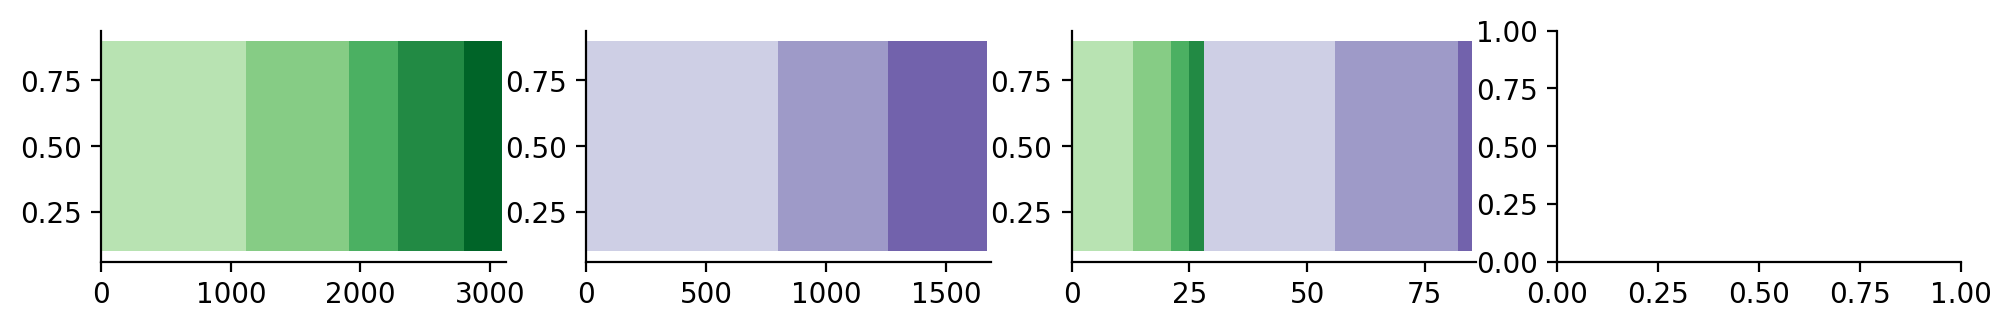

In [7]:
from depsurf import IssueEnum, Versions, DepKind
from depsurf.output import load_pkl, plot_yticks, get_legend_handles_labels, save_fig

from matplotlib import pyplot as plt
import numpy as np


results: "ResultsType" = load_pkl("src/summary")

kinds = [DepKind.FUNC, DepKind.STRUCT, DepKind.TRACEPOINT, DepKind.LSM]
fig, axs = plt.subplots(
    1,
    4,
    figsize=(12, 1.5),
    #  gridspec_kw={"wspace": 0.15, "hspace": 0.45},
)
axs = axs.flatten()

bottoms = [np.zeros(len(Versions.LTS)) for _ in kinds]
for i, ((group, pair), diffs) in enumerate(results.items()):
    if group != Versions.LTS:
        continue
    for (kind, key), s in diffs.items():
        if not isinstance(key, IssueEnum):
            continue
        if key in (IssueEnum.ADD, IssueEnum.REMOVE, IssueEnum.CHANGE):
            continue
        if s == 0:
            continue
        if kind not in kinds:
            continue

        kind_idx = kinds.index(kind)
        ax = axs[kind_idx]
        bottom = bottoms[kind_idx]

        ax.barh(i + 0.5, s, left=bottom[i], color=key.color, label=key)
        bottom[i] += s

for i, (ax, kind) in enumerate(zip(axs, kinds)):
    # ax.set_title(kind)
    ax.set_yticks(range(len(Versions.LTS)))
    ax.set_yticklabels([Versions.LTS.to_str(v) for v in Versions.LTS])
    # plot_yticks(ax)
    ax.set_xlabel(f"No. of {kind} Changes")
    if i == 0:
        # ax.set_ylabel("Number of Changes")
        ax.set_ylabel("LTS Kernel Versions")

    if kind in (DepKind.FUNC, DepKind.STRUCT):

        handles, labels = get_legend_handles_labels(ax)
        fig.legend(
            handles,
            labels,
            loc="upper center",
            ncol=len(handles),
            bbox_to_anchor=(0.5, 1.25 - i * 0.125),
            # handlelength=1.6,
            # handletextpad=0.4,
            # columnspacing=1.2,
        )

# fig.supxlabel("Number of Changes", y=-0.15)
# fig.supylabel("Linux LTS Kernel Versions", y=-0.075)
save_fig(fig, "change")